# Analytical solvers for simple step protocols

In the previous notebooks we used a [myokit.Simulation](https://myokit.readthedocs.io/en/latest/api_simulations/Simulation.html#myokit.Simulation) object to run simulations.
This simulator is based on [CVODE](https://computing.llnl.gov/projects/sundials) and provides excellent performance for a wide-variety of problems.

However, many voltage protocols consist entirely of flat, constant-voltage, steps, and models of ion currents can usually be solved analytically for a fixed V.
So in many cases it will be possible to simulate a step protocol by treating it as a sequence of fixed-voltage problems and solving analytically.
Myokit contains two classes to do just that.

## Analytical solutions for Hodgkin-Huxley models

First, we look at Hodgkin-Huxley (HH) models, and use the module [myokit.lib.hh](https://myokit.readthedocs.io/en/latest/api_library/hh.html) to isolate and solve them.

As usual, we begin by loading the model and protocol.

In [2]:
import myokit

model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

Next, we import `myokit.lib.hh`, and use the method [HHModel.from_component()](https://myokit.readthedocs.io/en/latest/api_library/hh.html#myokit.lib.hh.HHModel.from_component) to create a [HHModel](https://myokit.readthedocs.io/en/latest/api_library/hh.html#myokit.lib.hh.HHModel)  object.
Because we want to be able to parametrise this model, we specify the variables we'll want to change.

In [3]:
import myokit.lib.hh

# Specify the variables to keep as parameters
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]

# Create a parametrisable HH model
hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

We can do some fun stuff with this model:

In [4]:
print(hh_model.steady_state(membrane_potential=-80))

[0.00030894931556590987, 0.60081119944226]


But we can also use it to create a [myokit.lib.hh.AnalyticalSimulation](https://myokit.readthedocs.io/en/latest/api_library/hh.html#myokit.lib.hh.AnalyticalSimulation) object and run simulations.

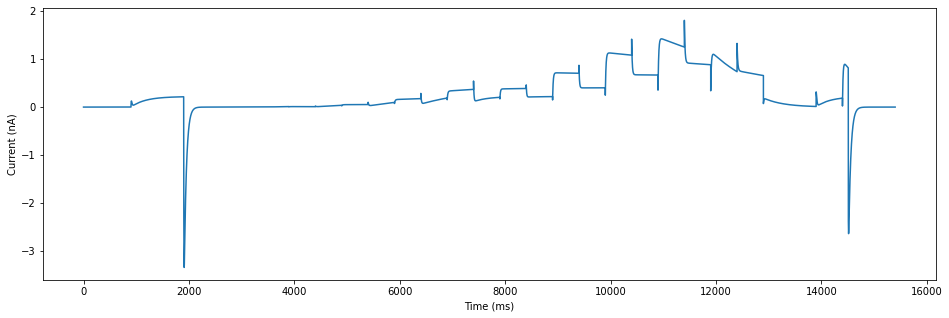

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Load a protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Create an analytical simulation
hh_sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)

# Select times to log
tmax = 15400
times = np.arange(0, tmax, 0.1)

# Run a simulation and plot the results
log = hh_sim.run(tmax, log_times=times)

plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, log['ikr.IKr'])
plt.show()

We can compare these results with a CVODE-based simulation:

0.01198969199322164
0.06237926700123353


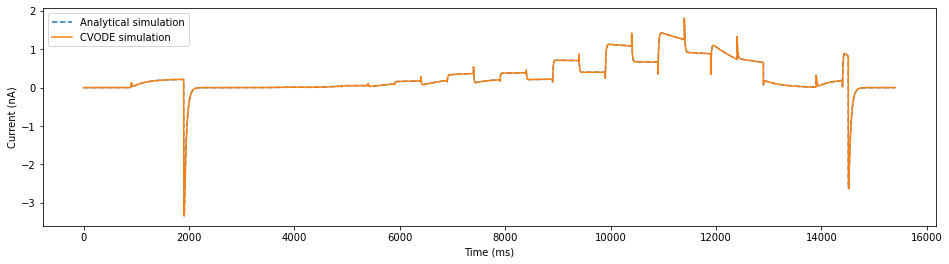

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import myokit
import myokit.lib.hh

# Load a model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Load a protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

# Create an analytical simulation
hh_sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)

# Create a CVODE simulation
cvode_sim = myokit.Simulation(model, protocol)

# Select times to log
tmax = 15400
times = np.arange(0, tmax, 0.1)

# Run a timed simulation with each method:
b = myokit.Benchmarker()
hh_log = hh_sim.run(tmax, log_times=times)
print(b.time())

b.reset()
cvode_log = cvode_sim.run(tmax, log_times=times, log=['ikr.IKr'])
print(b.time())

plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, log['ikr.IKr'], '--', label='Analytical simulation')
plt.plot(times, log['ikr.IKr'], '-', label='CVODE simulation')
plt.legend(loc='upper left')
plt.show()

So this method of solving can be quite a bit faster than using a generic ODE solver!

Another advantage is that it doesn't suffer from the "numerical noise" we discussed in the previous notebook, so we don't need to worry about solver tolerances.

### Troubleshooting

Note that there are a few tricks needed to make the above method work.
In particular, the `HHModel` class must be able to interpret the `myokit.Model` equations and isolate the steady-state and time constant variables for each state.
This requires knowing which variable represents the membrane potential.

To solve this, the model code we used in this example has annotated the membrane potential with a _label_ `membrane_potential`.
We can see this as follows:

In [7]:
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the membrane potential, using knowledge of the component and variable name
V = model.get('membrane.V')

# This variable has a label:
print(V.label())

membrane_potential


We can access variables through their label:

In [8]:
V = model.label('membrane_potential')
print(V.qname())

membrane.V


And we can add labels in code too:

In [9]:
ikr = model.get('ikr.IKr')
print(ikr.label())
ikr.set_label('ikr_current')
print(ikr.label())

None
ikr_current


As well as removing them:

In [10]:
ikr.set_label(None)
print(ikr.code())

IKr = g * act * rec * (V - nernst.EK)
    in [nA]



## Analytical solutions for Markov models

If our ion current model is written as a Markov model, we can use a similar method as above, but using the module [myokit.lib.markov](https://myokit.readthedocs.io/en/latest/api_library/markov.html).

This time, we create a [myokit.lib.markov.LinearModel](https://myokit.readthedocs.io/en/latest/api_library/markov.html#myokit.lib.markov.LinearModel), and use a [myokit.lib.markov.AnalyticalSimulation](https://myokit.readthedocs.io/en/latest/api_library/markov.html#myokit.lib.markov.AnalyticalSimulation):

0.024170823002350517
0.06401891900168266


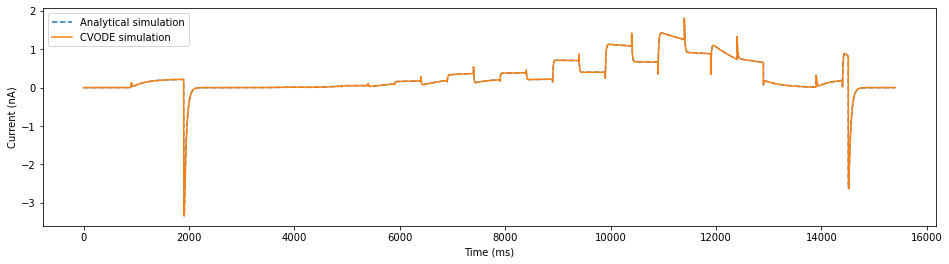

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import myokit
import myokit.lib.markov

# Load a model: this is the same model as before, but coded up as a Markov model (a kinetic scheme)
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')

# Load a protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)

# Create an analytical simulation
markov_sim = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol)

# Create a CVODE simulation
cvode_sim = myokit.Simulation(model, protocol)

# Select times to log
tmax = 15400
times = np.arange(0, tmax, 0.1)

# Run a timed simulation with each method:
b = myokit.Benchmarker()
hh_log = markov_sim.run(tmax, log_times=times)
print(b.time())

b.reset()
cvode_log = cvode_sim.run(tmax, log_times=times, log=['ikr.IKr'])
print(b.time())

plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, log['ikr.IKr'], '--', label='Analytical simulation')
plt.plot(times, log['ikr.IKr'], '-', label='CVODE simulation')
plt.legend(loc='upper left')
plt.show()

Again we see a reasonable speed-up compared to CVODE, which will be very welcome when fitting.

## Just for fun: single channel simulations

Markov models can also be used for discrete single channel simulations.

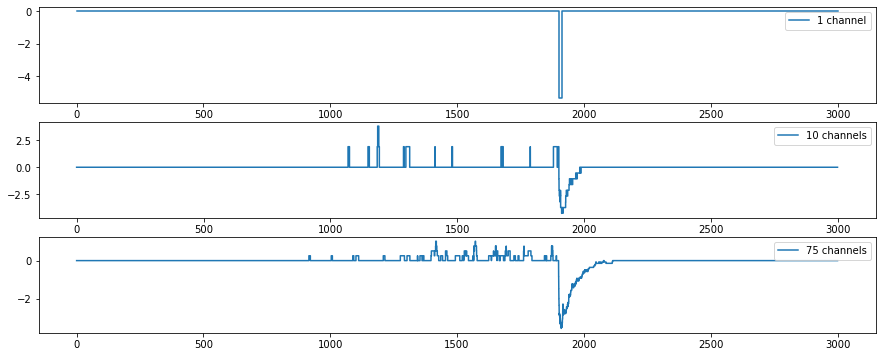

In [13]:
# Create a figure
plt.figure(figsize=(15,6))

# Simulate the first three seconds of the protocol, with various numbers of channels
sim = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels=1)
log = sim.run(3000)
plt.subplot(3, 1, 1)
plt.plot(log.time(), log['ikr.IKr'], drawstyle='steps-post', label='1 channel')
plt.legend()

sim = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels=10)
log = sim.run(3000)
plt.subplot(3, 1, 2)
plt.plot(log.time(), log['ikr.IKr'], drawstyle='steps-post', label='10 channels')
plt.legend()

sim = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels=75)
log = sim.run(3000)
plt.subplot(3, 1, 3)
plt.plot(log.time(), log['ikr.IKr'], drawstyle='steps-post', label='75 channels')
plt.legend()

plt.show()

## Summary

In this notebook we have seen that

- Analytical solvers for Hodgkin-Huxley and Markov models can be used to simulate the response to step protocols.
- These solvers can provide a speed-up over CVODE-based simulation, and avoid issues with solver tolerance.

In the next notebook we'll look at traditional step protocols, and how to combine multiple protocols into a single fit.